In [1]:

import cartopy
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import metpy.calc as mpcalc
import json
import calendar
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

import matplotlib.ticker as mticker
import matplotlib.font_manager as font_manager
import matplotlib.patches as mpatches
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import num2date
import matplotlib.pyplot as plt

In [73]:
ds = xr.open_dataset("/home/gabriel/_Gabriel/Estudo/netcdf/Geop_500hPA_month.nc")
periodo = ['1979-01-01','2010-01-01']
 
data = ds.sel(time=slice(periodo[0], periodo[1]))
data_season = data.groupby("time.season").mean()
data_list = []
for i in range(0, len(data.time.values), 12):
    d_slice = data.isel(time=slice(i, i+12))
    d_season = d_slice.groupby("time.season").mean()
    data_list.append(d_season)
        

In [76]:
data_season

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 81, longitude: 241, season: 4)
Coordinates:
  * longitude  (longitude) float32 -48.0 -47.75 -47.5 -47.25 ... 11.5 11.75 12.0
  * latitude   (latitude) float32 -20.0 -20.25 -20.5 ... -39.5 -39.75 -40.0
  * expver     (expver) int32 1 5
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    z          (season, expver, latitude, longitude) float32 57446.902 ... nan

In [92]:
maximoDJF = data_list[0].isel(season=0).z.max()
data_list[0].where(data_list[0].z==maximoDJF, drop=True)

<xarray.Dataset>
Dimensions:    (expver: 1, latitude: 1, longitude: 1, season: 1)
Coordinates:
  * longitude  (longitude) float32 -4.75
  * latitude   (latitude) float32 -21.75
  * expver     (expver) int32 1
  * season     (season) object 'DJF'
Data variables:
    z          (season, expver, latitude, longitude) float32 57650.625

In [120]:
max_mensal = data_list[0].isel(season=0)
max_data = max_mensal.where(max_mensal==max_mensal.z.max(), drop=True)
latitude = max_data.latitude
longitude = max_data.longitude
max_data.z.values

array([[[57650.625]]], dtype=float32)

In [22]:
dados = xr.open_dataset("D:/netcdf/Geopotencial/geopot_500hPA.nc")
dados = dados.isel(expver=0).drop('expver')
dados = dados.rename({'latitude':'lat'}).rename({'longitude':'lon'})
dados

<xarray.Dataset>
Dimensions:  (lat: 161, lon: 281, time: 501)
Coordinates:
  * lon      (lon) float32 -60.0 -59.75 -59.5 -59.25 ... 9.25 9.5 9.75 10.0
  * lat      (lat) float32 0.0 -0.25 -0.5 -0.75 ... -39.25 -39.5 -39.75 -40.0
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-09-01
Data variables:
    z        (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-27 19:34:50 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [3]:
def season_coords(ds, periodo):
    
    # Nesta função o dataset(ds) original é recortado para o período de análise e retorna uma LISTA DE DATASETS e UM DATASET
    # A lista 'data_list' retornada contém os datasets.season de cada intervalo de UM ANO dentro do RANGE do 'periodo de recorte'
    # EX:: ASSUMINDO QUE 'PERIODO' É [1979-12-01, 2010-11-01] <--> 'DATA_LIST[0]' retornará o dataset.season do intervalo de ..
    # ... (Continuando)... >> [1979-12-01 até 1980-11-01] <<< EQUIVALENTE AO INTERVALO UM ANO (DATA_LIST[0])
    # O dataset 'data_season' retornado é o dataset.season de TODO o RANGE do 'periodo de recorte'
    # Logo, o 'data_season' é a média.SEASON do intervalo completo do dataset recortado
    # EX:: ASSUMINDO QUE PERIODO >> [1979-12-01, 2010-11-01] << --> 'DATA_SEASON' retornará o dataset.season do PERIODO
    
    data = ds.sel(time=slice(periodo[0], periodo[1]))
    data_season = data.groupby("time.season").mean()
    data_list = []
    for i in range(0, len(data.time.values), 12):
        d_slice = data.isel(time=slice(i, i+12))
        d_season = d_slice.groupby("time.season").mean()
        data_list.append(d_season)
        
    return data_list, data_season

In [7]:
def season_scat(ax, ds, season, hems, periodo, periodobase=None, media_periodo=False, media_base=False, only_media=False):
    
    # Nesta função é plotado o gráfico de distribuição 'SCATTER_PLOT' dos pontos máximos de pressão gerados 
    # Função suporta até DOIS períodos para comparação --> periodobase = periodo opcional para a comparação (climatologias)
    # Os parâmetros 'periodo' e 'periodobase' plotam os pontos de máxima para os datasets.season (DATA_LIST) ...
    #... (Continuando)... retornados para seus respectivos intervalos de 'periodo' e 'periodobase', enquanto os ...
    #... (Continuando)... *KWARGS 'media_periodo' e 'media_base' plotam para o dataset.season (DATA_SEASON) from 'SEASON_COORDS' 
    # O parametro only_media é um *KWARG que permite ao usuário, caso TODOS os outros *kwargs sejam =! dos valores default ...
    #... (Continuando)..., ou seja << periodobase != NONE AND medias !=FALSE >>, plotar somente os valores (DATA_SEASON)
    
    
    # IMPORTANDO 'DATA_SEASON' E 'DATA_LIST' CORRESPONDENTES AO INTERVALOR 'PERIODO'
    seasons, seasons_mean = season_coords(ds, periodo)
    
    # LISTA COM AS LABELS DOS SCATTER POINTS
    handles = []
    
    # CUIDADO: --> 'summer' é o verão do hemisfério Norte (JJA) <-> inverno do hemisfério (SUL) 'inverno'
    if hems == "Sul":
        if season == "verão" or season =="ver":
            season_index = 0
        elif season == "inverno" or season == "inv":
            season_index = 1
        elif season == "outono" or season == "out":
            season_index = 2
        elif season == "primavera" or season == "pri":
            season_index = 3
            
    elif hems == "Norte":
        if season == "winter" or season == "win":
            season_index = 0
        elif season == "summer" or season == "sum":
            season_index = 1
        elif season == "spring" or season == "spr":
            season_index = 2
        elif season == "autumn" or season == "aut":
            season_index = 3
        
    if only_media == False: 
        
        # Média Sazonal para cada intervalos de um ano <-> MÚLTIPLOS scatter points (!!!)
        # Formatando o dataset para o recorte do valor máximo de 'z', retornando seu VALOR e COORDS
        # Plotando os scatter points <-> pontos de máximo
        for data in seasons:
            max_mensal = data.isel(season=season_index)
            max_data = max_mensal.where(max_mensal==max_mensal.z.max(), drop=True)
            latitude = np.nanmax(max_data.lat)
            longitude = np.mean(max_data.lon)
            valores, xs, ys = max_data.z, longitude, latitude         
            ax.scatter(xs, ys, transform=ccrs.PlateCarree(), color='orangered', alpha=0.5)
        cyan_patch_1 = mpatches.Patch(color='orangered', label=f"{periodo[0][0:4]} to {periodo[1][0:4]}", capstyle="round")
        handles.append(cyan_patch_1)
        
    if media_periodo == True:
        
        # Média sazonal para o período completo <-> ÚNICO scatter point (!!!)
        # Formatando o dataset para o recorte do valor máximo de 'z', retornando seu VALOR e COORDS
        # Plotando os scatter points <-> pontos de máximo
        max_season_mean = seasons_mean.isel(season=season_index)
        max_data_mean = max_season_mean.where(max_season_mean==max_season_mean.z.max(), drop=True)
        latitude_mean = np.nanmax(max_data_mean.lat)
        longitude_mean = np.mean(max_data_mean.lon)
        valores, xs, ys = max_data_mean.z, longitude_mean, latitude_mean  
        if only_media == False:
            ax.scatter(xs, ys, s=300, transform=ccrs.PlateCarree(), color='orangered', alpha=1, marker='v')
        else:
            ax.scatter(xs, ys, s=200, transform=ccrs.PlateCarree(), color='orangered', alpha=1, marker='x', label=f"{periodo[0][0:4]} to {periodo[1][0:4]}", capstyle="round")

    if periodobase != None:
        # IMPORTANDO 'DATA_SEASON' E 'DATA_LIST' CORRESPONDENTES AO INTERVALOR 'PERIODOBASE'
        seasons_2, seasons_mean_2 = season_coords(ds, periodobase)
        
        if only_media == False:
            # MESMOS RACIOCÍNIOS, AGORA APLICADOS PARA O SEGUNDO PERIODO DE COMPARAÇÃO (periodobase) != None
            for data in seasons_2:
                max_mensal_2 = data.isel(season=season_index)
                max_data_2 = max_mensal_2.where(max_mensal_2==max_mensal_2.z.max(), drop=True)
                latitude_2 = np.nanmax(max_data_2.lat)
                longitude_2 = np.mean(max_data_2.lon)
                valores, xs, ys = max_data_2.z, longitude_2, latitude_2         
                ax.scatter(xs, ys, transform=ccrs.PlateCarree(), color='darkcyan', alpha=0.5)
            cyan_patch_3 = mpatches.Patch(color='darkcyan', label=f"{periodobase[0][0:4]} to {periodobase[1][0:4]}", capstyle="round")
            handles.append(cyan_patch_3)
            
        if media_base == True:
            # MESMOS RACIOCÍNIOS, AGORA APLICADOS PARA O SEGUNDO PERIODO DE COMPARAÇÃO (periodobase) != None
            max_season_mean_2 = seasons_mean_2.isel(season=season_index)
            max_data_mean_2 = max_season_mean_2.where(max_season_mean_2==max_season_mean_2.z.max(), drop=True)
            latitude_mean_2 = np.nanmax(max_data_mean_2.lat)
            longitude_mean_2 = np.mean(max_data_mean_2.lon)
            valores, xs, ys = max_data_mean_2.z, longitude_mean_2, latitude_mean_2
            if only_media == False:
                ax.scatter(xs, ys, s=300, transform=ccrs.PlateCarree(), color='darkcyan', alpha=1, marker='v')
            else:
                ax.scatter(xs, ys, s=200, transform=ccrs.PlateCarree(), color='darkcyan', alpha=1, marker="x", label=f"{periodobase[0][0:4]} to {periodobase[1][0:4]}", capstyle="round")
   
    if only_media == True:
        # TÍTULO DA LEGENDA QUANDO HÁ SÓ OS VALORES DE 'DATA_SEASON' <-> 'ONLY_MEDIA == TRUE'
        ax.legend(title="Max Position", title_fontsize=12, loc="upper right", fancybox=True, shadow=True, labelspacing=1.0, borderpad=0.7)
    else:
        # SEM TÍTULO DE LEGENDA PARA 'ONLY_MEDIA == FALSE'
        ax.legend(handles=handles, prop=font_manager.FontProperties(style='oblique', size=12), loc="upper right", fancybox=True, shadow=True)
        
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='gray')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.ylines = True
    gl.xlines = True
    #gl.xlocator = mticker.FixedLocator(np.arange(-180, 200, 10))
    #gl.ylocator = mticker.FixedLocator(np.arange(-180, 200, 5))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}

    ax.set_extent([ds.lon.values.min(), ds.lon.values.max(), ds.lat.values.min(), ds.lat.values.max()], crs=ccrs.PlateCarree())         
    ax.coastlines()
    ax.set_title(seasons_mean.season[season_index].values, loc='left', fontsize=20, style="oblique")
    ax.set_title("LAMMOC-UFF", loc='right', fontsize=9, style="oblique")

In [8]:
def figura_scat(hems, periodo, periodobase=None, media_periodo=False, media_base=False, only_media=False):
    
    fig, ax = plt.subplots(ncols = 2, nrows = 2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(20, 10))
    fig.suptitle("Maximum geopotential height values at 500 hPa", fontsize=30, fontstyle='oblique')
    
    if hems == "Sul":
        season_scat(ax[0,0], dados, "ver", hems, periodo, periodobase, media_periodo, media_base, only_media)
        season_scat(ax[0,1], dados, "inv", hems, periodo, periodobase, media_periodo, media_base, only_media)
        season_scat(ax[1,0], dados, "out", hems, periodo, periodobase, media_periodo, media_base, only_media)
        season_scat(ax[1,1], dados, "pri", hems, periodo, periodobase, media_periodo, media_base, only_media)
        
    if hems == "Norte":
        season_scat(ax[0,0], dados, "win", hems, periodo, periodobase, media_periodo, media_base, only_media)
        season_scat(ax[0,1], dados, "sum", hems, periodo, periodobase, media_periodo, media_base, only_media)
        season_scat(ax[1,0], dados, "spr", hems, periodo, periodobase, media_periodo, media_base, only_media)
        season_scat(ax[1,1], dados, "aut", hems, periodo, periodobase, media_periodo, media_base, only_media)

    # plt.savefig("z_MAX_Scatt_Mean.png")
    # plt.savefig("z_MAX_Mean.png")
    # plt.savefig("z_MAX_Scatt.png")


C:\Users\gabri\miniconda3\envs\gab\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\gabri\miniconda3\envs\gab\lib\site-packages\cartopy\mpl\gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
C:\Users\gabri\miniconda3\envs\gab\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\gabri\miniconda3\envs\gab\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .x

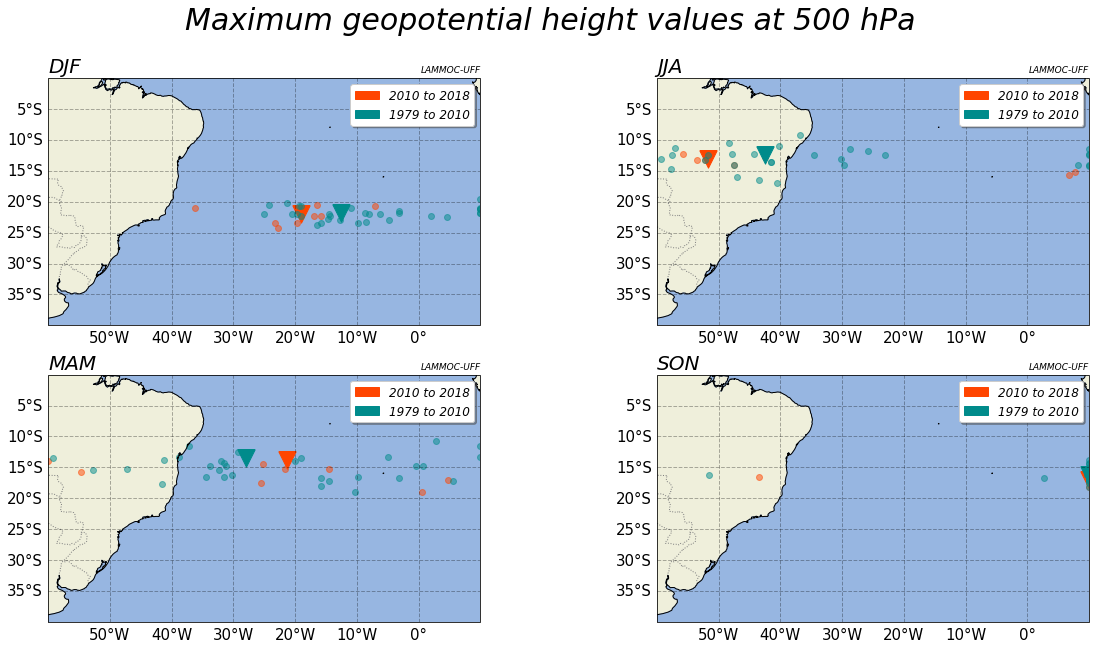

In [26]:
figura_scat("Sul", ["2010-12-01", "2018-11-01"], ["1979-12-01", "2010-11-01"], media_periodo=True, media_base=True)
plt.savefig('geop_500_season_largecut')

# Month Analysis

In [28]:
xr.open_dataset("/home/gabriel/_Gabriel/Estudo/netcdf/Geop_500hPA_month.nc").z

<xarray.DataArray 'z' (time: 501, expver: 2, latitude: 81, longitude: 241)>
[19560042 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -48.0 -47.75 -47.5 -47.25 ... 11.5 11.75 12.0
  * latitude   (latitude) float32 -20.0 -20.25 -20.5 ... -39.5 -39.75 -40.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-09-01
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [10]:
def set_data(periodo, periodo_base):
    data = xr.open_dataset("D:/netcdf/Geopotencial/geopot_500hPA.nc")  
    z = data.isel(expver=0).drop('expver')
    z = z.rename({'latitude':'lat'}).rename({'longitude':'lon'})
    
    time_slice_p = slice(periodo[0],periodo[1])
    media_mes_p = z.sel(time=time_slice_p).groupby('time.month').mean()
    
    time_slice_base = slice(periodo_base[0],periodo_base[1])
    media_mes_base = z.sel(time=time_slice_base).groupby('time.month').mean()
    
    lons_base = media_mes_base.lon.values
    lats_base = media_mes_base.lat.values
    
    lons_p = media_mes_p.lon.values
    lats_p = media_mes_p.lat.values
    
    return lons_base, lats_base, media_mes_base, lons_p, lats_p, media_mes_p

In [17]:
def month_coords(periodo):
    
    # Nesta função o dataset(ds) original é recortado para o período de análise e retorna uma LISTA DE DATASETS e UM DATASET
    # A lista 'data_list' retornada contém os datasets.season de cada intervalo de UM ANO dentro do RANGE do 'periodo de recorte'
    # EX:: ASSUMINDO QUE 'PERIODO' É [1979-12-01, 2010-11-01] <--> 'DATA_LIST[0]' retornará o dataset.season do intervalo de ..
    # ... (Continuando)... >> [1979-12-01 até 1980-11-01] <<< EQUIVALENTE AO INTERVALO UM ANO (DATA_LIST[0])
    # O dataset 'data_season' retornado é o dataset.season de TODO o RANGE do 'periodo de recorte'
    # Logo, o 'data_season' é a média.SEASON do intervalo completo do dataset recortado
    # EX:: ASSUMINDO QUE PERIODO >> [1979-12-01, 2010-11-01] << --> 'DATA_SEASON' retornará o dataset.season do PERIODO
    dados = xr.open_dataset("D:/netcdf/Geopotencial/geopot_500hPA.nc")
    dados = dados.isel(expver=0).drop('expver')
    dados = dados.rename({'latitude':'lat'}).rename({'longitude':'lon'})  
    
    data = dados.sel(time=slice(periodo[0], periodo[1]))
    data_month = data.groupby("time.month").mean()
    data_list_month = []
    for i in range(0, len(data.time.values), 12):
        d_slice = data.isel(time=slice(i, i+12))
        d_month = d_slice.groupby("time.month").mean()
        data_list_month.append(d_month)
        
    return data_list_month, data_month

In [18]:
def figura12(periodo_base, periodo):
    fig, ax = plt.subplots(nrows=3,ncols=4,subplot_kw=dict(projection = ccrs.PlateCarree()), figsize=(25,12))
    fig.suptitle("Maximum geopotential height values at 500 hPa", fontsize=30, fontstyle='oblique')
    
    mes = [1,2,3,4,5,6,7,8,9,10,11,12]
       
    plott12(ax[0,0], mes[0],periodo_base, periodo)      # OBS: Pra essa figura, algumas pequenas alterações são feitas na função 'plott'                                            
    plott12(ax[0,1], mes[1],periodo_base, periodo)      #      Alterações de formatação, como títulos, distanciamento do colorbar e etc...
    plott12(ax[0,2], mes[2],periodo_base, periodo)
    plott12(ax[0,3], mes[3],periodo_base, periodo)
    plott12(ax[1,0], mes[4],periodo_base, periodo)
    plott12(ax[1,1], mes[5],periodo_base, periodo)
    plott12(ax[1,2], mes[6],periodo_base, periodo)
    plott12(ax[1,3], mes[7],periodo_base, periodo)
    plott12(ax[2,0], mes[8],periodo_base, periodo)
    plott12(ax[2,1], mes[9],periodo_base, periodo)
    plott12(ax[2,2], mes[10],periodo_base, periodo)
    plott12(ax[2,3], mes[11],periodo_base, periodo)
    
    ax[0][0].set_title('LAMMOC-UFF', fontdict={'fontsize': 20}, loc = 'left')

In [192]:
lista, full = month_coords(["1979-01-01", "2010-12-01"])

In [204]:
abril = lista[18].sel(month=4)
abrilmax = abril.where(abril==abril.max(),drop=True)
abrilmax

<xarray.Dataset>
Dimensions:  (lat: 1, lon: 4)
Coordinates:
  * lon      (lon) float32 8.75 9.0 9.25 9.5
  * lat      (lat) float32 -20.0
    month    int64 4
Data variables:
    z        (lat, lon) float32 57526.582 57526.582 57526.582 57526.582

C:\Users\gabri\miniconda3\envs\gab\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\gabri\miniconda3\envs\gab\lib\site-packages\cartopy\mpl\gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
C:\Users\gabri\miniconda3\envs\gab\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\gabri\miniconda3\envs\gab\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .x

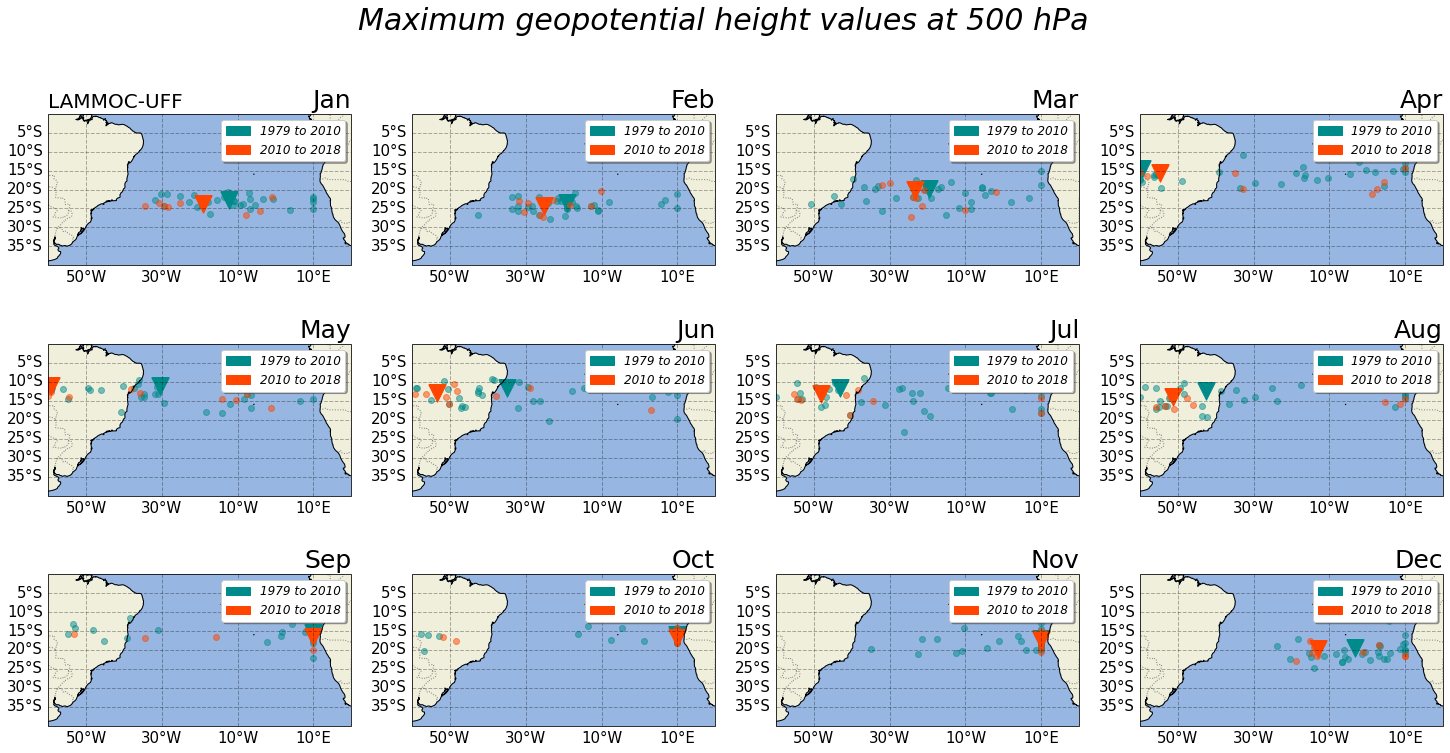

In [20]:
figura12(["1979-01-01", "2010-12-01"], ["2010-01-01", "2018-12-01"])
plt.savefig('geop_500_month_largecut')

In [13]:
def plott12(ax, mes, periodo_base, periodo):
    
    handles = []
    
    data_list_month, data_month = month_coords(periodo)
    data_list_month_base, data_month_base = month_coords(periodo_base)
    
    #PONTO A PONTO BASE

    for ano in data_list_month_base:
        max_mensal_b = ano.sel(month=mes)
        max_data_b = max_mensal_b.where(max_mensal_b==max_mensal_b.z.max(), drop=True)
        latitude3 = np.mean(max_data_b.lat)
        longitude3 = np.mean(max_data_b.lon)
        valores3, xs3, ys3 = max_data_b.z, longitude3, latitude3
        ax.scatter(xs3, ys3, transform=ccrs.PlateCarree(), color='darkcyan', alpha=0.5)
    cyan_patch_2 = mpatches.Patch(color='darkcyan', label=f"{periodo_base[0][0:4]} to {periodo_base[1][0:4]}", capstyle="round")
    handles.append(cyan_patch_2)   
    
    #MEDIA ABAIXO
    
    max_mensal_mean_2 = data_month_base.sel(month=mes)
    max_data_mean_2 = max_mensal_mean_2.where(max_mensal_mean_2==max_mensal_mean_2.z.max(), drop=True)
    latitude_mean_2 = np.mean(max_data_mean_2.lat)
    longitude_mean_2 = np.mean(max_data_mean_2.lon)
    valores, xs4, ys4 = max_data_mean_2.z, longitude_mean_2, latitude_mean_2
    ax.scatter(xs4, ys4, s=300, transform=ccrs.PlateCarree(), color='darkcyan', alpha=1, marker='v')
    
    
    #PONTO A PONTO PERIODO
    
    for ano in data_list_month:
        max_mensal = ano.sel(month=mes)
        max_data = max_mensal.where(max_mensal==max_mensal.z.max(), drop=True)
        latitude = np.mean(max_data.lat)
        longitude = np.mean(max_data.lon)
        valores, xs, ys = max_data.z, longitude, latitude
        ax.scatter(xs, ys, transform=ccrs.PlateCarree(), color='orangered', alpha=0.5)
    cyan_patch_1 = mpatches.Patch(color='orangered', label=f"{periodo[0][0:4]} to {periodo[1][0:4]}", capstyle="round")
    handles.append(cyan_patch_1) 
    
    #MEDIA PERIODO ABAIXO
    
    max_mensal_mean = data_month.sel(month=mes)
    max_data_mean = max_mensal_mean.where(max_mensal_mean==max_mensal_mean.z.max(), drop=True)
    latitude_mean = np.nanmax(max_data_mean.lat)
    longitude_mean = np.mean(max_data_mean.lon)
    valores2, xs2, ys2 = max_data_mean.z, longitude_mean, latitude_mean  
    ax.scatter(xs2, ys2, s=300, transform=ccrs.PlateCarree(), color='orangered', alpha=1, marker='v')
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.ylines = True
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator(np.arange(-70, 50, 20)) #-70,50,20
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='gray')
    
    ax.coastlines('50m')
    ax.set_extent([-60, 20, 0, -40], crs=ccrs.PlateCarree()) 
    ax.set_title(calendar.month_abbr[mes], fontdict={'fontsize': 25}, loc = 'right')
    ax.legend(handles=handles, prop=font_manager.FontProperties(style='oblique', size=12), loc="upper right", fancybox=True, shadow=True)


In [2]:
pip install statsmodels

     |████████████████████████████████| 9.5 MB 7.3 MB/s eta 0:00:01     |██████████▍                     | 3.1 MB 1.6 MB/s eta 0:00:04
     |████████████████████████████████| 231 kB 5.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [27]:
import sys
sys.path.append("C:/Users/gabri/Github/Climatologia")
import climsy as cs

In [28]:
geo = cs.get_dataset('D:/netcdf/Geopotencial/geopot_500hPA.nc','ERA-5')
base = geo.formatter(time=["1979-01-01","2010-12-01"])
base.dataset.attrs['level']=500
ana = geo.formatter(time=["2010-01-01","2018-12-01"])
ana.dataset.attrs['level']=500

In [29]:
base_clima = base.climatology()
ana_clima = ana.climatology()

C:\Users\gabri\miniconda3\envs\gab\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\gabri\miniconda3\envs\gab\lib\site-packages\cartopy\mpl\gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
C:\Users\gabri\miniconda3\envs\gab\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


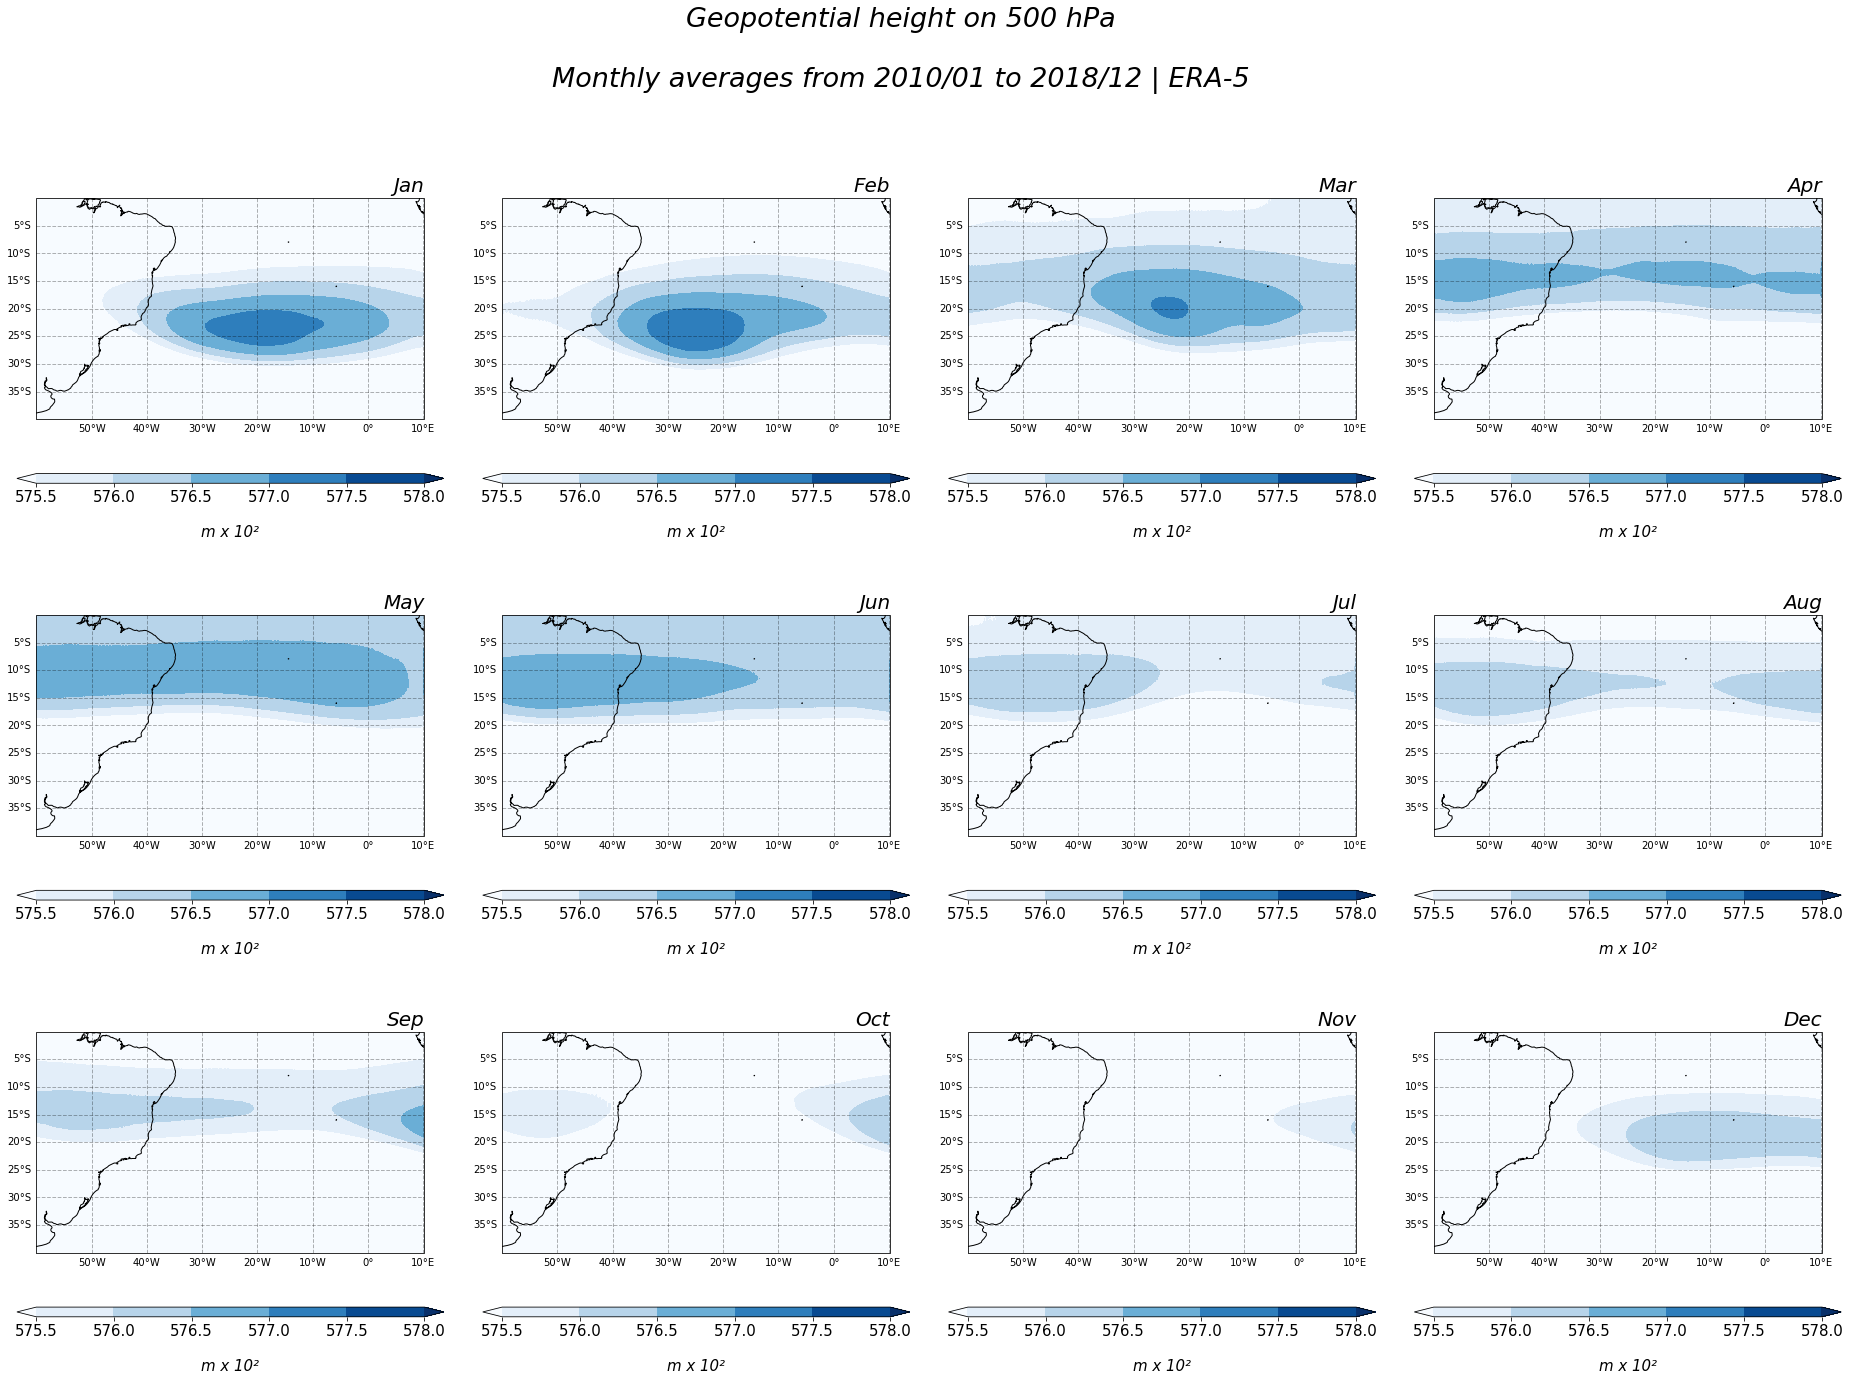

In [30]:
ana_clima.data_view.multiplots()
plt.savefig('observação_largecut')